In [1]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import medmnist
from PIL import Image
from medmnist import INFO, Evaluator
from tensorflow.keras.utils import plot_model
from clearml import Task, OutputModel, Logger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import seaborn as sns

## Dataset Preparation and Visualization

{'python_class': 'BloodMNIST', 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.', 'url': 'https://zenodo.org/records/10519652/files/bloodmnist.npz?download=1', 'MD5': '7053d0359d879ad8a5505303e11de1dc', 'url_64': 'https://zenodo.org/records/10519652/files/bloodmnist_64.npz?download=1', 'MD5_64': '2b94928a2ae4916078ca51e05b6b800b', 'url_128': 'https://zenodo.org/records/10519652/files/bloodmnist_128.npz?download=1', 'MD5_128': 'adace1e0ed228fccda1f39692059dd4c', 'url_224': 'https://zenodo.org/records/10519652/files/bloodmnist_224.npz

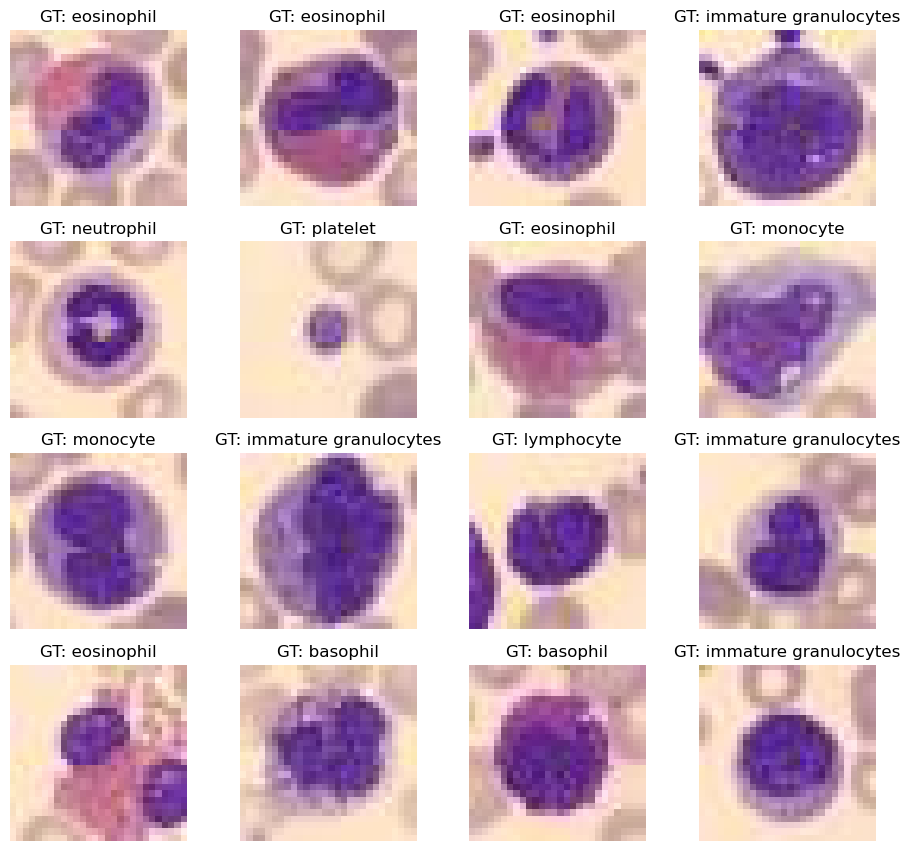

In [2]:
# BloodMNIST dataset information
data_flag = 'bloodmnist'
info = INFO[data_flag]
n_channels = info['n_channels']
classes = info['label']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

cml_labels = {classes[str(i)]: i for i in range(n_classes)}
print(info)

# Normalize data and class convertiong into one-hot encoded label
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values ranging from 0 to 255 to 0 and 1
    image = (image - 0.5) / 0.5  # Normalize to [-1, 1] and centered around 0
    label = tf.one_hot(label, n_classes) #One-hot encoding transforms the integer class label into a binary vector of length n_classes
    return image, label

#load data
train_dataset = DataClass(split='train', transform=None, download=True)
val_dataset = DataClass(split='val', transform=None, download=True)
test_dataset = DataClass(split='test', transform=None, download=True)

print(f'Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}')

# count the number of samples in each class
count = []
for i in range(n_classes):
    count.append((train_dataset.labels == i).sum())
    print(f'{classes[str(i)]}: {count[i]}')

def dataset_to_tf(data, batch_size):
    images = []
    labels = []
    for img, lbl in data:
        images.append(np.array(img))
        labels.append(lbl[0])  # Convert to a scalar
    images = np.stack(images)
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(preprocess)
    return dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    
batch_size = 2048
sample_size = 16

train_loader = dataset_to_tf(train_dataset, batch_size)
val_loader = dataset_to_tf(val_dataset, batch_size)
test_loader = dataset_to_tf(test_dataset, batch_size)

# Show some random training images
images, labels = next(iter(train_loader))
plt.figure()
for i in range(sample_size):
    fig = plt.subplot(4, 4, i + 1)
    plt.imshow((images[i].numpy() * 0.5 + 0.5).squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'GT: {classes[str(tf.argmax(labels[i]).numpy())][:21]}')
    
plt.subplots_adjust(right=1.5, top=1.8)
plt.show()


# The DNN

In [30]:

def build_dnn_model(input_shape):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))  # Flatten the input
    model.add(Dense(1024, activation='relu'))  # First fully connected layer
    model.add(Dense(128, activation='relu'))   # Second fully connected layer
    model.add(Dropout(0.25))  # Dropout layer for regularization
    model.add(Dense(8, activation='softmax'))  # Output layer with softmax activation

    return model

input_shape = (28, 28, 3)
dnn_model = build_dnn_model(input_shape)

dnn_model.summary()

plot_model(dnn_model, to_file='dnn_model.png', show_shapes=True)
#set environment for clearML
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=UM467TGFU1L1ICCP9LHV
%env CLEARML_API_SECRET_KEY=eBhwfcZCImDq6FZSTDByWrfCAMLsKA5D0ZzUfUuW9i2uYFMkPJ

train_number = 1 
task = Task.init(project_name="BloodMNIST-Group6", task_name=f"DNN training {train_number}")
learning_rate = 0.001
dnn_model.compile(optimizer=Adam(learning_rate), 
                  loss=CategoricalCrossentropy(), 
                  metrics=['accuracy'])

# Update hyperparameters to ClearML
params = {
    "number_of_epochs": 50,
    "batch_size": batch_size,
    "base_lr": learning_rate,
    "decrease_lr": "by 10 every 30 epochs",
    "loss_func": "CategoricalCrossentropy",
    "optimizer": "Adam"
}
params = task.connect(params)

# Upload model to ClearML
output_model = OutputModel(task=task)
output_model.update_labels(cml_labels)
output_model.update_design(config_dict=dnn_model.get_config())

# Callbacks for ClearML
class ClearMLCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        Logger.current_logger().report_scalar("Loss", "training loss", iteration=epoch, value=logs["loss"])
        Logger.current_logger().report_scalar("Accuracy", "training accuracy", iteration=epoch, value=logs["accuracy"])
        Logger.current_logger().report_scalar("Loss", "val loss", iteration=epoch, value=logs["val_loss"])
        Logger.current_logger().report_scalar("Accuracy", "val accuracy", iteration=epoch, value=logs["val_accuracy"])

checkpoint = ModelCheckpoint(filepath='model_{epoch}.keras', save_best_only=True, monitor='val_loss', mode='min')

# Training the model
history = dnn_model.fit(train_loader, 
                        epochs=50, 
                        validation_data=val_loader, 
                        callbacks=[ClearMLCallback(), checkpoint])

# Evaluate the model
test_loss, test_accuracy = dnn_model.evaluate(test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Close ClearML task
task.close()

print('Finished Training')
dnn_model.save('DNN_model.keras')


/Users/liuyuechen/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     2,409,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,541,704 (9.70 MB)

 Trainable params: 2,541,704 (9.70 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.
env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=UM467TGFU1L1ICCP9LHV
env: CLEARML_API_SECRET_KEY=eBhwfcZCImDq6FZSTDByWrfCAMLsKA5D0ZzUfUuW9i2uYFMkPJ
ClearML Task: created new task id=b607d326946f4c8682ce4420319b7e61
2024-06-08 14:23:49,873 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/b7e1b6a8e7ea4cac83038d4e2dee6907/experiments/b607d326946f4c8682ce4420319b7e61/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 900ms/step - accuracy: 0.2189 - loss: 2.6480 - val_accuracy: 0.4433 - val_loss: 1.4259
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4147 - loss: 1.4998 - val_accuracy: 0.6355 - val_loss: 1.1502
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━

## Plotting the Learning Curves for DNN Model

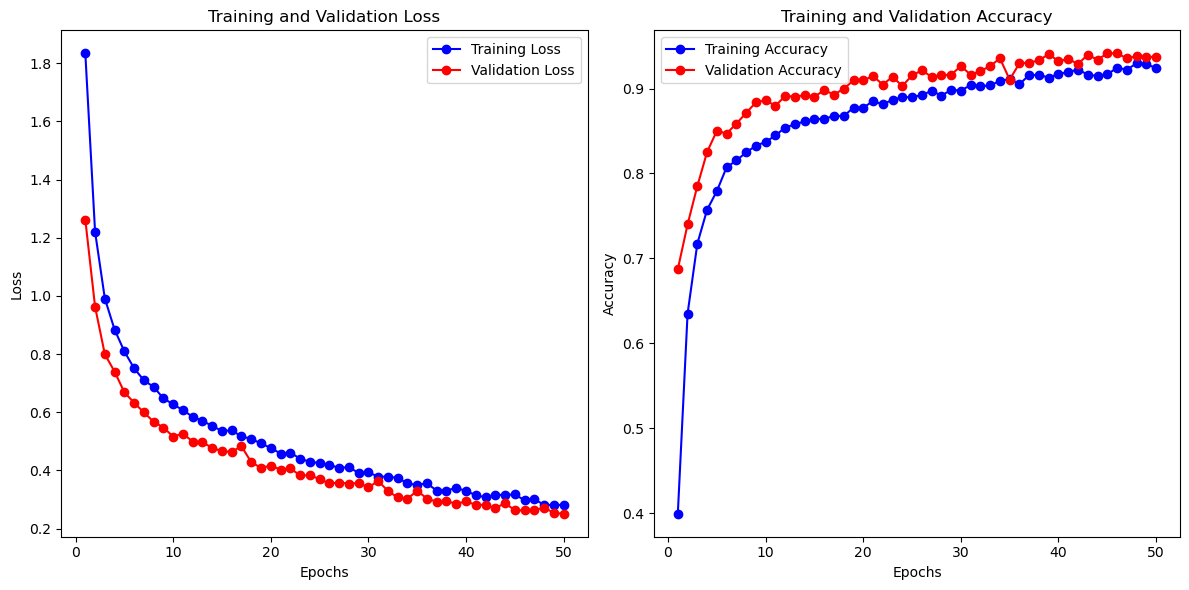

In [28]:
import matplotlib.pyplot as plt

# Access the history from the training session
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Create subplot for loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Create subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Plotting the ROC curve for DNN model

In [29]:
# Make predictions
y_pred_prob = dnn_model.predict(X_test)

# Binarize the labels in a one-vs-all fashion for ROC computation
y_test_binarized = label_binarize(np.argmax(y_test, axis=1), classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
cell_types = [info['label'][str(i)] for i in range(n_classes)]
colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple', 'brown', 'pink']

# Plot all ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

for i, (cell_type, color) in enumerate(zip(cell_types, colors)):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
                   ''.format(cell_type, roc_auc[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves - for DNN model')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curves.pdf")
plt.show()

NameError: name 'dnn_model' is not defined

## Plotting the F1 Scores for DNN Model

In [26]:
from sklearn.metrics import f1_score

# Make predictions on the test set
y_pred = dnn_model.predict(test_loader)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert true labels to binary format
y_true_labels = np.argmax(y_test, axis=1)

# Calculate F1 score for each class
f1_scores = f1_score(y_true_labels, y_pred_labels, average=None)

cell_types = [info['label'][str(i)] for i in range(n_classes)]

# Plot F1 scores for each class
plt.figure(figsize=(8, 6))
plt.bar(range(n_classes), f1_scores, color='skyblue')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Class')
plt.xticks(range(n_classes), cell_types, rotation=45, ha='right')
plt.tight_layout()
plt.show()

NameError: name 'dnn_model' is not defined

## Plotting the Confusion Matrix for DNN Model

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


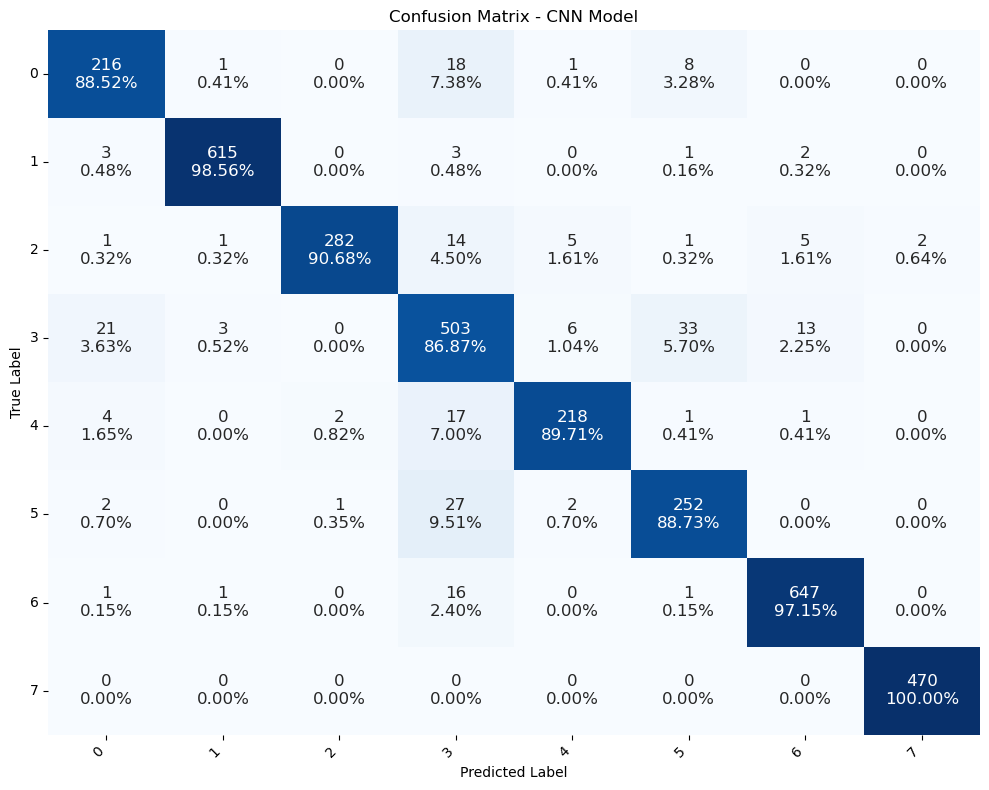

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the test data
y_pred = cnn_model.predict(X_test)

# Convert predictions and true labels to class indices
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_class, y_pred_class)

# Normalize the confusion matrix by the number of samples in each class
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create annotations with both percentage and count
labels = np.array([[f"{value}\n{percentage:.2%}" for value, percentage in zip(row, row_normalized)] 
                   for row, row_normalized in zip(conf_matrix, conf_matrix_normalized)])

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=labels, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 12})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN Model')
plt.xticks(np.arange(n_classes) + 0.5, labels=classes, rotation=45, ha='right')
plt.yticks(np.arange(n_classes) + 0.5, labels=classes, rotation=0, va='center')
plt.tight_layout()
plt.show()

# CNN


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from medmnist import INFO, Evaluator
from medmnist.info import INFO
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, Input, LeakyReLU, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2


data_flag = 'bloodmnist'
info = INFO[data_flag]
n_channels = info['n_channels']
classes = info['label']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

# Load data
train_dataset = DataClass(split='train', download=True)
val_dataset = DataClass(split='val', download=True)
test_dataset = DataClass(split='test', download=True)

######################################try the data
# Extract X_test and y_test from the dataset
X_test = np.stack([np.array(data[0]) for data in test_dataset])
y_test = np.array([data[1] for data in test_dataset])

# Normalize and preprocess X_test
X_test = X_test.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
X_test = (X_test - 0.5) / 0.5  # Further scale to [-1, 1]

# Convert y_test to one-hot encoded labels
y_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)

print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

######################################end

# Define the input and convolutional layers of the model
inputs = Input(shape=(28, 28, n_channels))
conv1 = Conv2D(32, (3, 3), activation='relu')(inputs)
pool1 = MaxPooling2D((2, 2))(conv1)
drop1 = Dropout(0.25)(pool1)  # Add dropout layer

conv2 = Conv2D(64, (3, 3), activation='relu')(drop1)
pool2 = MaxPooling2D((2, 2))(conv2)
drop2 = Dropout(0.25)(pool2)  # Add dropout layer

flattened = Flatten()(drop2)
hidden = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(flattened)  # Add L2 regularization
drop3 = Dropout(0.5)(hidden)  # Add dropout layer

outputs = Dense(n_classes, activation='softmax')(drop3)  # Using softmax for multi-class classification




Using downloaded and verified file: /Users/liuyuechen/.medmnist/bloodmnist.npz
Using downloaded and verified file: /Users/liuyuechen/.medmnist/bloodmnist.npz
Using downloaded and verified file: /Users/liuyuechen/.medmnist/bloodmnist.npz
Shape of X_test: (3421, 28, 28, 3)
Shape of y_test: (3421, 8)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 450,706 (1.72 MB)

 Trainable params: 225,352 (880.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 225,354 (880.29 KB)

# run either optimizer and then run the predict

# The SGD optimizer for CNN model

In [11]:
# Create the model
cnn_model = Model(inputs=inputs, outputs=outputs)

# Compile the model with SGD optimizer and categorical cross-entropy loss
cnn_model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.1)

cnn_model.summary()


Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.2896 - loss: 2.0813 - val_accuracy: 0.6873 - val_loss: 1.2619
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5966 - loss: 1.3186 - val_accuracy: 0.7400 - val_loss: 0.9628
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7107 - loss: 1.0175 - val_accuracy: 0.7851 - val_loss: 0.7995
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7486 - loss: 0.9048 - val_accuracy: 0.8253 - val_loss: 0.7397
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7704 - loss: 0.8419 - val_accuracy: 0.8503 - val_loss: 0.6686
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8053 - loss: 0.7511 - val_accuracy: 0.8470 - val_loss: 0.6330
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8083 - loss: 0.7260 - val_accuracy: 0.8587 - val_loss: 0.5995
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8302 - loss: 0.6870 - val_accuracy: 0.8712 - v

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 450,706 (1.72 MB)

 Trainable params: 225,352 (880.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 225,354 (880.29 KB)

# The Adam optimizer for CNN model

In [10]:
# Create the model
cnn_model = Model(inputs=inputs, outputs=outputs)

# Compile the model with SGD optimizer and categorical cross-entropy loss
cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model on the training data
history =cnn_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.1)

# Print the model summary to verify the structure
model.summary()

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9386 - loss: 0.2483 - val_accuracy: 0.9431 - val_loss: 0.2259
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9426 - loss: 0.2304 - val_accuracy: 0.9373 - val_loss: 0.2451
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9452 - loss: 0.2275 - val_accuracy: 0.9473 - val_loss: 0.2242
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9429 - loss: 0.2279 - val_accuracy: 0.9431 - val_loss: 0.2288
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9451 - loss: 0.2291 - val_accuracy: 0.9415 - val_loss: 0.2316
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9472 - loss: 0.2246 - val_accuracy: 0.9448 - val_loss: 0.2305
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9440 - loss: 0.2298 - val_accuracy: 0.9398 - val_loss: 0.2241
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9456 - loss: 0.2227 - val_accuracy: 0.9440 - v

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 676,058 (2.58 MB)

 Trainable params: 225,352 (880.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 450,706 (1.72 MB)

In [11]:
# Predict probabilities for the test set
preds_nn = cnn_model.predict(X_test)

# Binarize the labels in a one-vs-all fashion for ROC computation
y_test_binarized = label_binarize(np.argmax(y_test, axis=1), classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], preds_nn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


## Plotting the Learning Curves for CNN Model

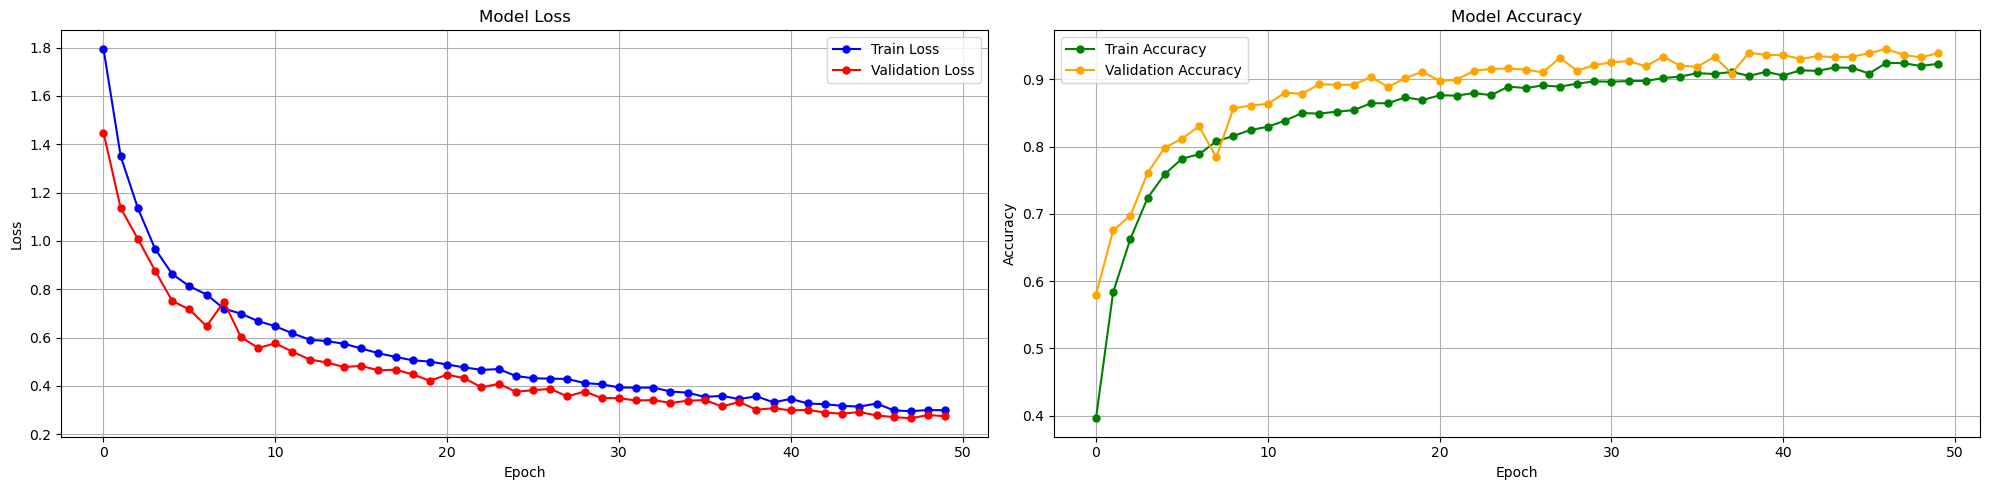

In [5]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 5))  # 1 row, 2 columns

# First subplot for loss
axs[0].plot(history.history['loss'], marker='o', linestyle='-', color='blue', markersize=5, label='Train Loss')
axs[0].plot(history.history['val_loss'], marker='o', linestyle='-', color='red', markersize=5, label='Validation Loss')
axs[0].set_title('Model Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='upper right')
axs[0].grid(True)

# Second subplot for accuracy
axs[1].plot(history.history['accuracy'], marker='o', linestyle='-', color='green', markersize=5, label='Train Accuracy')
axs[1].plot(history.history['val_accuracy'], marker='o', linestyle='-', color='orange', markersize=5, label='Validation Accuracy')
axs[1].set_title('Model Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper left')
axs[1].grid(True)

# Adjust layout
plt.tight_layout()

# Save the entire figure as a PDF file
plt.savefig("training_results.pdf")

# Show the plot
plt.show()


## Plotting the ROC Curve for CNN Model

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


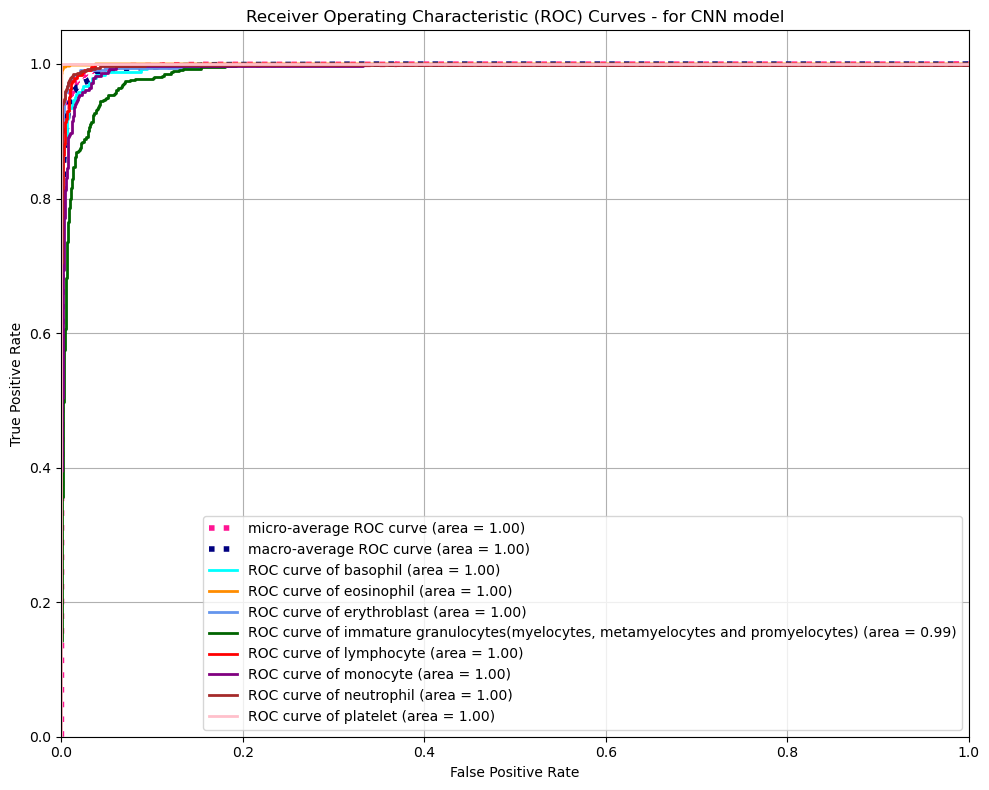

In [14]:
# Make predictions
y_pred_prob = cnn_model.predict(X_test)

# Binarize the labels in a one-vs-all fashion for ROC computation
y_test_binarized = label_binarize(np.argmax(y_test, axis=1), classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# Retrieve cell type names
cell_types = [info['label'][str(i)] for i in range(n_classes)]
colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple', 'brown', 'pink']
for i, (cell_type, color) in enumerate(zip(cell_types, colors)):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
                   ''.format(cell_type, roc_auc[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves - for CNN model')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curves.pdf")
plt.show()

## Plotting the F1 Scores for CNN Model

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


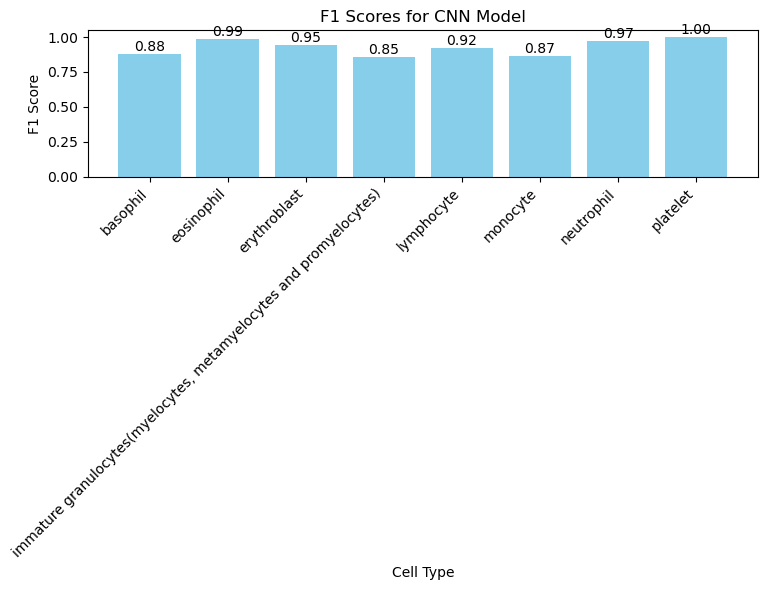

In [23]:
from sklearn.metrics import f1_score

# Make predictions on the test data
y_pred = cnn_model.predict(X_test)

# Convert predictions and true labels to class indices
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(y_test, axis=1)

# Compute F1 scores for each class
f1_scores = f1_score(y_true_class, y_pred_class, average=None)
cell_types = [info['label'][str(i)] for i in range(n_classes)]

# Plot F1 scores
plt.figure(figsize=(8, 6))
bars = plt.bar(range(n_classes), f1_scores, color='skyblue')

# Annotate bars with F1 score values
for bar, score in zip(bars, f1_scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{score:.2f}', ha='center', va='bottom')

plt.xticks(range(n_classes), cell_types, rotation=45, ha='right')
plt.xlabel('Cell Type')
plt.ylabel('F1 Score')
plt.title('F1 Scores for CNN Model')
plt.tight_layout()
plt.show()

## Plotting the Confusion Matrix for CNN Model

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


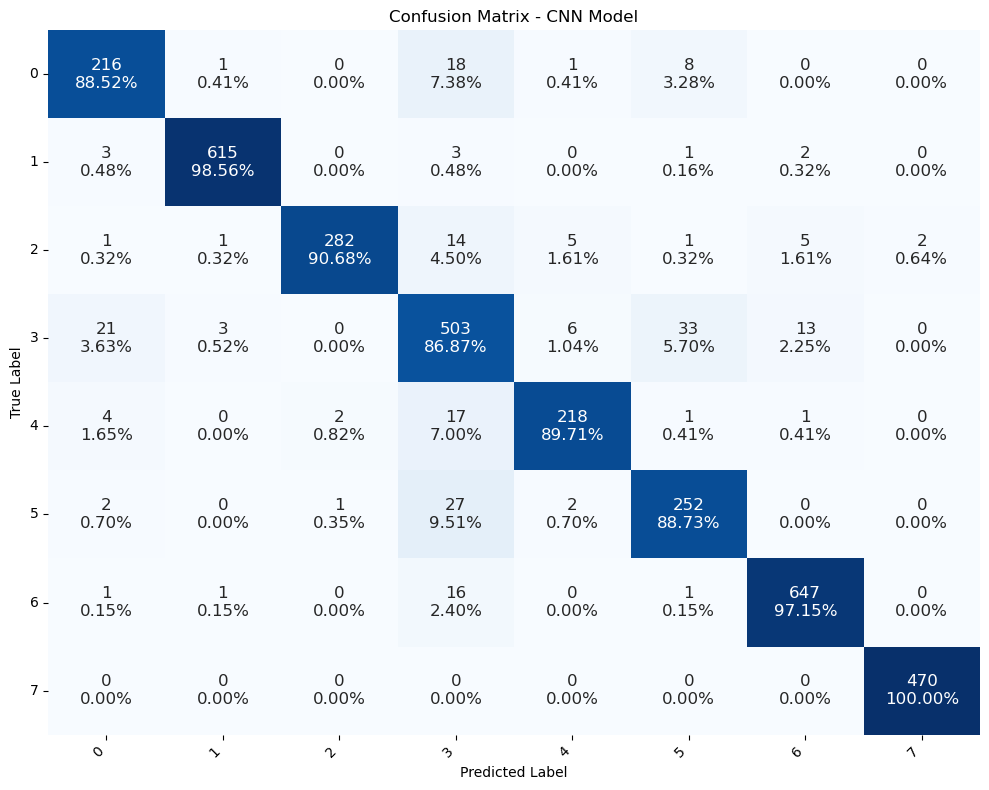

In [14]:
y_pred = cnn_model.predict(X_test)

y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(y_test, axis=1)


conf_matrix = confusion_matrix(y_true_class, y_pred_class)

# Normalize the confusion matrix by the number of samples in each class
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
labels = np.array([[f"{value}\n{percentage:.2%}" for value, percentage in zip(row, row_normalized)] 
                   for row, row_normalized in zip(conf_matrix, conf_matrix_normalized)])

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=labels, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 12})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN Model')
plt.xticks(np.arange(n_classes) + 0.5, labels=classes, rotation=45, ha='right')
plt.yticks(np.arange(n_classes) + 0.5, labels=classes, rotation=0, va='center')
plt.tight_layout()
plt.show()